# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Импорт необходимых библиотек

In [2]:
!pip install phik -q
!pip install -Uq scikit-learn

In [3]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import phik
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Подготовка данных

In [4]:
data = pd.read_csv('/datasets/autos.csv')

print(data.info())
display(data.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
328275,2016-04-03 21:48:25,6800,convertible,1998,manual,136,slk,150000,0,NaN,mercedes_benz,no,2016-04-03 00:00:00,0,86529,2016-04-03 21:48:25
319057,2016-03-25 18:57:59,1699,convertible,1994,manual,75,golf,150000,7,petrol,volkswagen,no,2016-03-25 00:00:00,0,38259,2016-04-07 01:44:22
288324,2016-03-11 22:06:17,4700,wagon,2005,manual,150,3er,150000,6,gasoline,bmw,no,2016-03-11 00:00:00,0,60329,2016-03-22 21:18:31
37118,2016-03-30 18:44:46,3500,coupe,1992,manual,190,other,150000,3,petrol,volkswagen,no,2016-03-30 00:00:00,0,96191,2016-04-07 09:45:18
49713,2016-03-20 05:03:00,950,small,2001,manual,54,seicento,150000,10,NaN,fiat,no,2016-03-20 00:00:00,0,28779,2016-04-06 02:46:52


<div style="border:solid Chocolate 2px; padding: 40px">
    
<font color = 'blue' size = 5> Для перехода к следующему пункту необходимо будет выполнить следующее: </font> 

0. Устранить явные и неявные дубликаты
1. Оценить пропуски, где необходимо заполнить их определенным значением или удалить. Типы данных соответствуют фичам, кроме дат, но от них избавимся на дальнейших этапах, т.к. они не несут в себе никакой информативной ценности (пункт 1.3). 
2. Произвести оценку количественных переменных, при наличии аномалий избавиться от них.
3. Произвести оценку качественных переменных. 
4. Провести корреляционный анализ

### Удаление дубликатов

Проверим на явные дубликаты

In [5]:
print(f'Количество явных дубликатов: {data.duplicated().sum()}')

Количество явных дубликатов: 4


In [6]:
data = data.drop_duplicates().reset_index(drop = True)

In [7]:
for i in ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']: 
    print(list(data[i].sort_values().unique()))

['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon', nan]
['auto', 'manual', nan]
['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol', nan]
['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']
['no', 'yes', nan]


<div style="border:solid Chocolate 2px; padding: 40px">
    
<font color = 'green'  size = 5> Результаты очистки от дубликатов </font>
    
- было обнаруженно 4 явных дубликата - устранены
- неявных дубликатов не обнаруженно 

### Оценка пропусков

In [8]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

<div style="border:solid Chocolate 2px; padding: 40px">
Пропуски обнаружены в следующих фичах: 
- VehicleType - тип автомобильного кузова
- Gearbox - тип коробки передач
- Model - модель автомобиля
- FuelType - тип топлива
- Repaired - была машина в ремонте или нет

<font color = 'red' size = 4>
    Выводы: </font>
    
1. все пропуски значений относятся к категориальным переменным    
2. Заполнить параметр МОДЕЛЬ АВТО каким то значением невозможно (медианой, константой..) избавимся от пропущенных значений.(удалим в последнем пункте, в удалении дубликатов, для того чтобы провести полний исследовательский анализ) (присвоим константу,заодно проверим какую долю составляют пропущенные значения)
3. Остальные все значения поставим заглушку в виде определенного значения 'Unknown' (используем pipeline) (невозможно поставить самое частое значение, т.к. скорее всего это внесет неправильную картину мира. Например, если форду как производителю мы присвоим самое частое значение модели авто Гольф. получится форд гольф, что заведомо ложно) 

In [9]:
def preprocessor_absence (df, features):
    transformer = Pipeline (steps = 
                               [
                                   ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown'))
                               ]
                           )
    preprocessor = ColumnTransformer (transformers = 
                                         [
                                             ('cat', transformer, features)
                                         ]
                                     )
    df[features] = preprocessor.fit_transform(df)
    
    return df

absence_features = data.select_dtypes(exclude = 'number').columns

preprocessor_absence(data, absence_features)

#выполнили заполнение пропусков, далее убедимся что пропусков нет 

data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Оценка количественных переменных 

*Напишем функцию для оценки количественных переменных* 

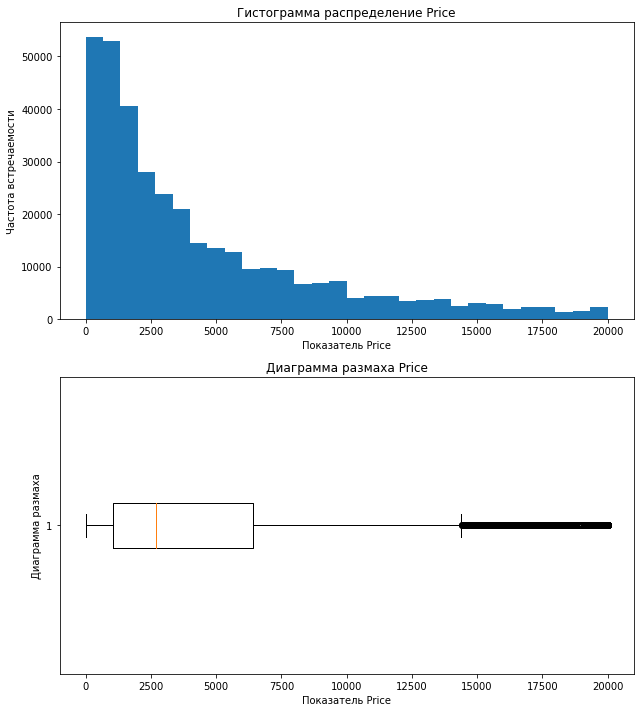

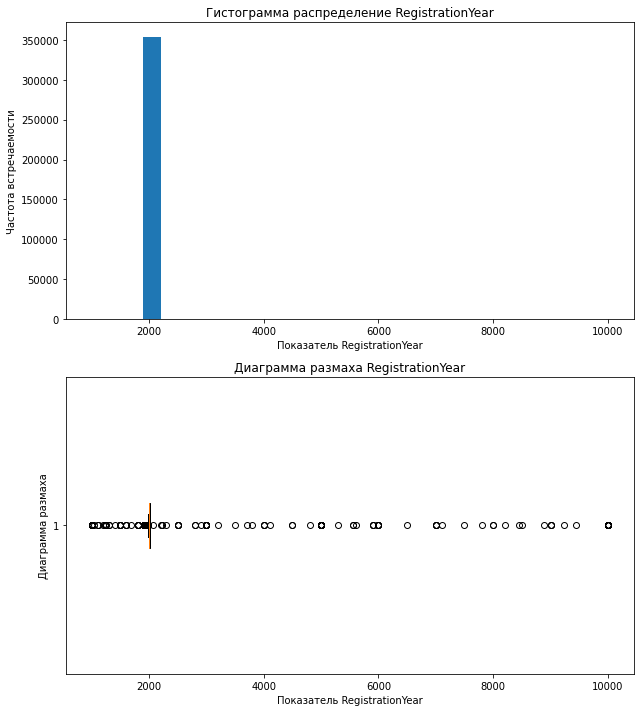

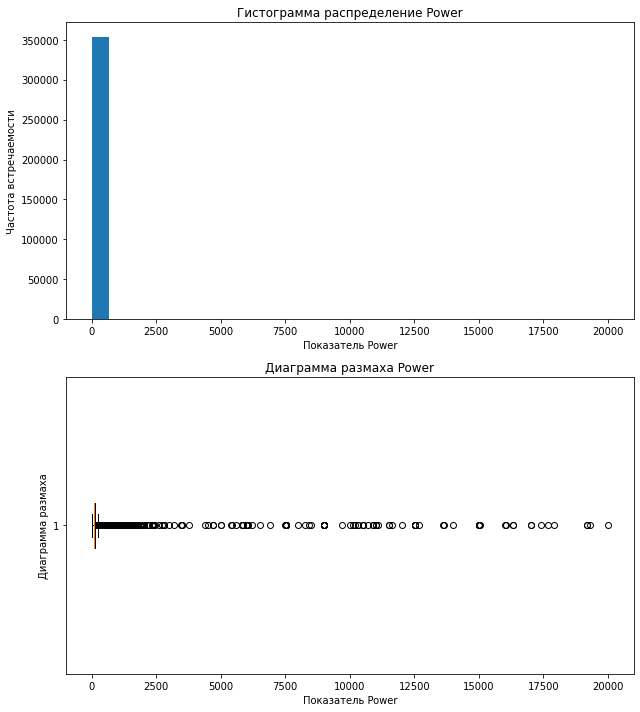

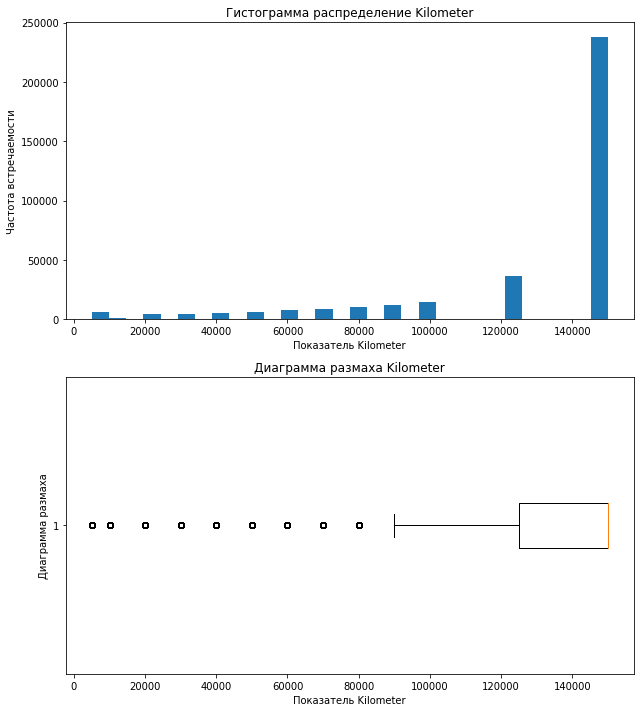

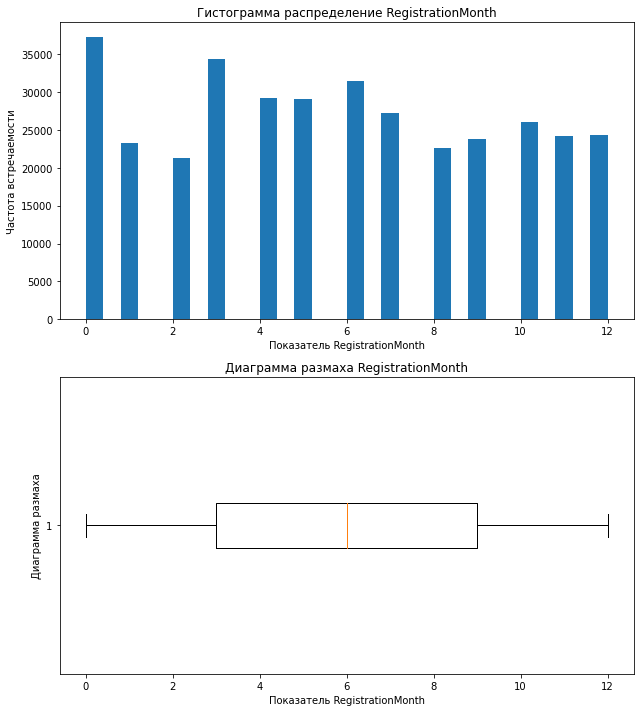

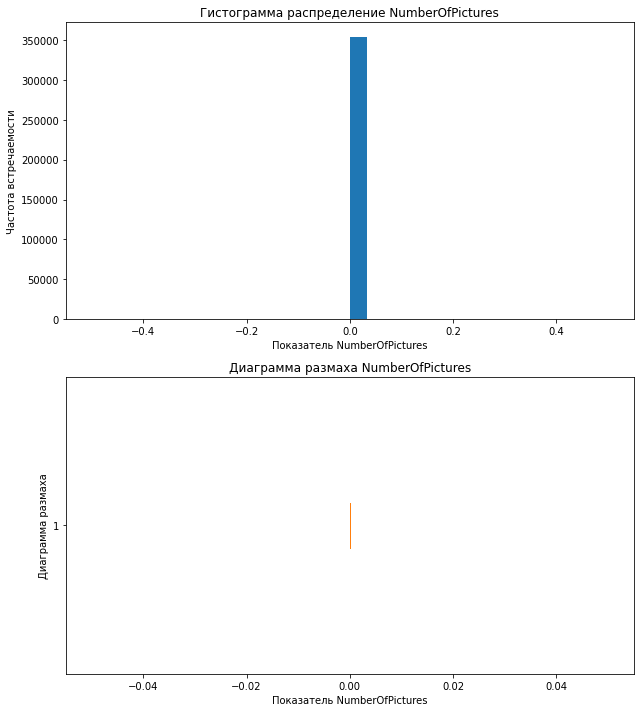

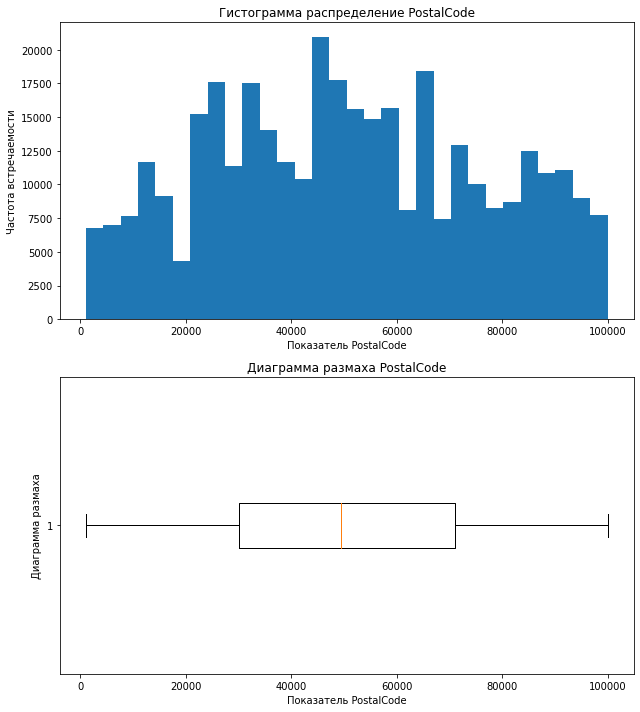

In [10]:
def num_discover(data):
    number_features = data.select_dtypes(include = 'number').columns
    for i in number_features: 
        fig, axes = plt.subplots(2, 1, figsize= (9, 10))

        axes[0].hist(data[i], bins=30)  
        axes[0].set_title(f'Гистограмма распределение {i}')
        axes[0].set_ylabel('Частота встречаемости')
        axes[0].set_xlabel(f'Показатель {i}')

        axes[1].boxplot(data[i], vert=False) 
        axes[1].set_title(f'Диаграмма размаха {i}')
        axes[1].set_ylabel('Диаграмма размаха')
        axes[1].set_xlabel(f'Показатель {i}')

        plt.tight_layout()
        plt.show()
        
num_discover(data) 

<font color = 'red' size = 4> Итоги предварительного исследовательского анализа количественных переменных: </font>

1. Необходимо изучить цену на авто у которых около 0 (возьмем порог 500 евро и изучим его), а так же рассмотрим > 14000
2. год регистрации автомобиля изучить аномалии в годах > 2024 и меньше условного 1980
3. мощность у автомобилей не будет < 50 or > 400 лошадиных сил
4. Количество фотографий - необходимо удалить как признак 
5. почтовый индекс владельца анкеты - необходимо удалить как признак 

Количество авто зарегистрированных после 2016 года =  14530
Количество авто зарегистрированных до 1980 года =  3452

Количество авто > 400 л.с. =  739
Количество авто < 10 л.с. =   40445
Количество авто < 30 л.с. =   41133
Количество авто < 50 л.с. =   46172


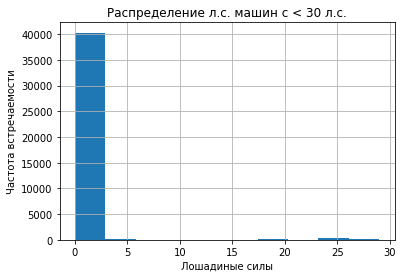

Данные по машинам < 30 л.с. скорее всего были занесены ошибочно (после проверки они все около нулевые, избавимся от них)

Избавимся от этих данных


In [11]:
#Устранение аномалий в годе регистрации автомобиля

print(f'Количество авто зарегистрированных после 2016 года = ', len(data[(data['RegistrationYear'] > 2016)]), sep = ' ')
print(f'Количество авто зарегистрированных до 1980 года = ', len(data[(data['RegistrationYear'] < 1980)]), sep = ' ')
print(f'')
print(f'Количество авто > 400 л.с. = ', len(data[(data['Power'] > 400)]), sep = ' ')
print(f'Количество авто < 10 л.с. =  ', len(data[(data['Power'] < 10)]), sep = ' ')
print(f'Количество авто < 30 л.с. =  ', len(data[(data['Power'] < 30)]), sep = ' ')
print(f'Количество авто < 50 л.с. =  ', len(data[(data['Power'] < 50)]), sep = ' ')
data[(data['Power'] < 30)]['Power'].hist()
plt.title('Распределение л.с. машин с < 30 л.с.')
plt.ylabel('Частота встречаемости')
plt.xlabel('Лошадиные силы')
plt.show()
print(f'Данные по машинам < 30 л.с. скорее всего были занесены ошибочно (после проверки они все около нулевые, избавимся от них)')
print(f'')
print(f'Избавимся от этих данных')

data = data.drop(data[(data['RegistrationYear'] > 2016) | (data['RegistrationYear'] < 1980) | 
                      (data['Power'] > 400) | (data['Power'] < 30)].index).reset_index(drop = True)


**Изучим распределение Года регистрации автоммобиля и кол-ва лошадиных сил** 

**Изучим распределение цены**

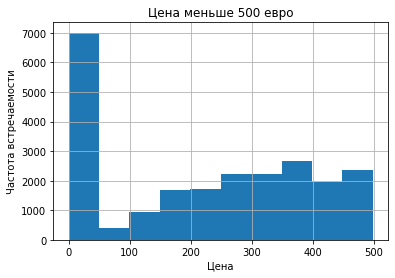

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
12320,2016-03-30 14:47:09,15600,wagon,2010,auto,184,3er,150000,10,gasoline,bmw,Unknown,2016-03-30 00:00:00,0,84130,2016-03-30 14:47:09
162229,2016-03-20 19:56:39,15550,convertible,2007,manual,200,a4,80000,11,petrol,audi,no,2016-03-20 00:00:00,0,74523,2016-04-07 04:17:39
26446,2016-03-10 19:52:34,19500,sedan,1990,manual,160,golf,125000,8,petrol,volkswagen,no,2016-03-10 00:00:00,0,38442,2016-03-12 11:18:03
188090,2016-03-06 14:52:36,15900,wagon,2008,manual,211,a4,90000,7,petrol,audi,no,2016-03-06 00:00:00,0,87527,2016-03-17 11:47:29
107765,2016-03-10 11:36:55,18950,suv,2014,manual,163,antara,70000,3,gasoline,opel,no,2016-03-10 00:00:00,0,14656,2016-04-07 00:16:02
8081,2016-04-01 21:47:22,17000,bus,1999,manual,102,Unknown,150000,11,gasoline,volkswagen,no,2016-04-01 00:00:00,0,32312,2016-04-03 19:16:01
82166,2016-03-07 01:42:31,18500,sedan,2007,auto,280,q7,125000,10,petrol,audi,no,2016-03-06 00:00:00,0,83666,2016-04-05 15:17:47


Удалим все цены меньше 100 евро, выбросы сверху имеют право на существование, т.к. на превышают 4 квантиль в несколько раз


In [12]:
data[(data['Price'] < 500)]['Price'].hist()
plt.title('Цена меньше 500 евро')
plt.ylabel('Частота встречаемости')
plt.xlabel('Цена')
plt.show()

display(data[(data['Price'] > 15000)].sample(7))
print(f'Удалим все цены меньше 100 евро, выбросы сверху имеют право на существование, т.к. на превышают 4 квантиль в несколько раз')

data = data.drop(data[(data['Price'] < 100)].index).reset_index(drop = True)

In [13]:
#Удаление признака "Кол-во фотографий" и "почтовый индекс"
data = data.drop(columns = ['PostalCode', 'NumberOfPictures'])

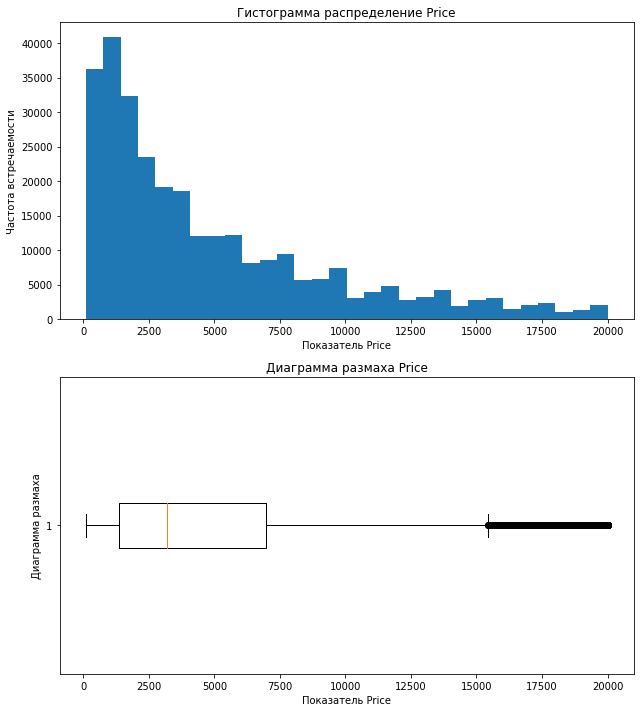

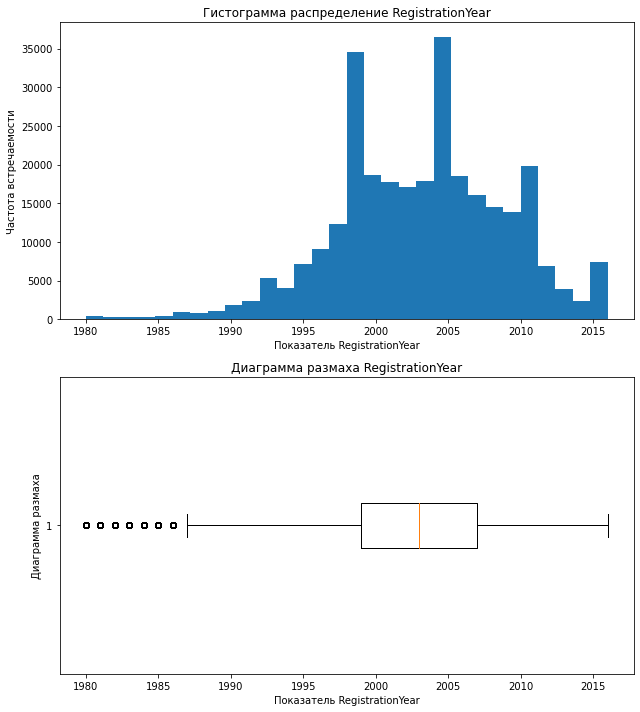

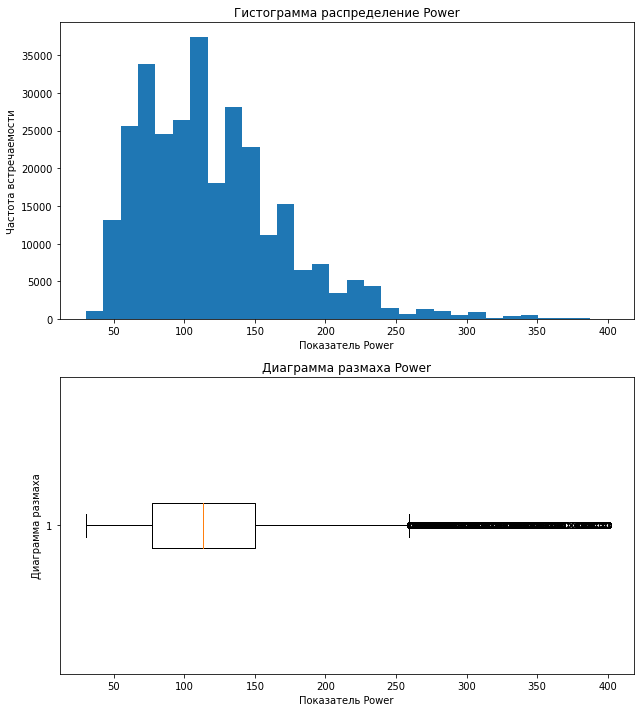

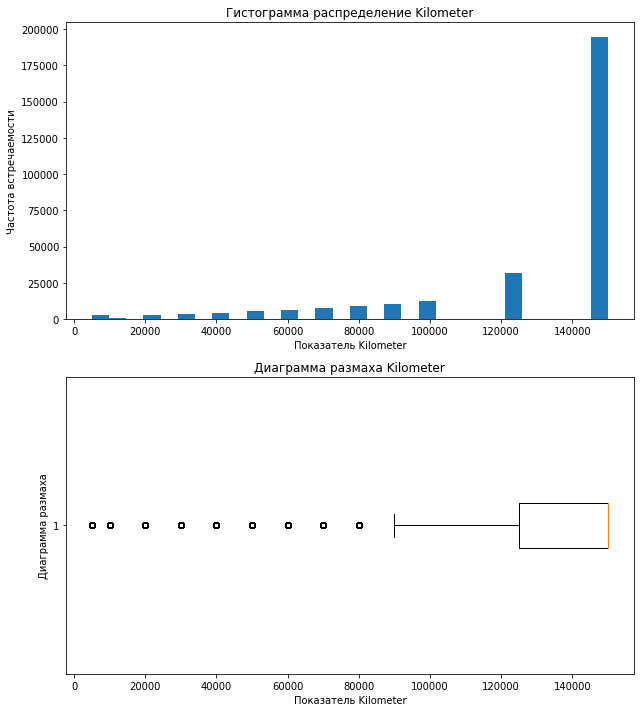

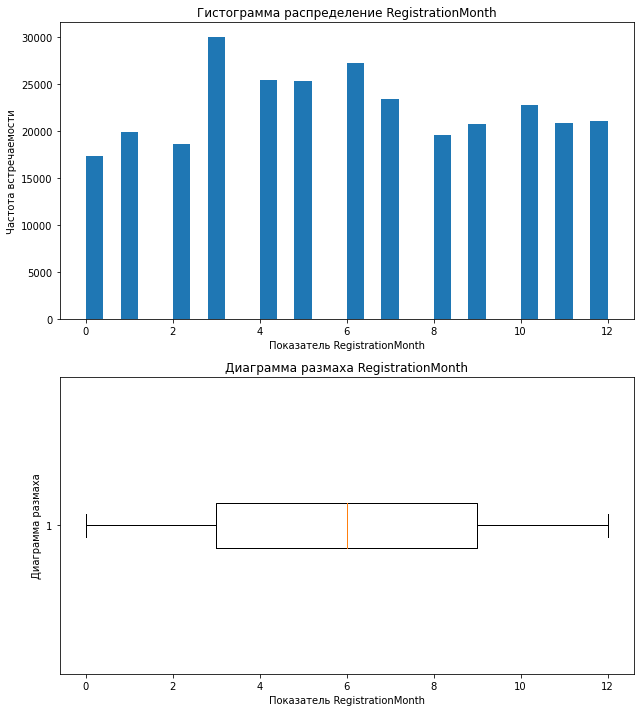

In [14]:
# повторный вызов функции для исследовательского анализа количественных переменных
num_discover(data) 

<div style="border:solid Chocolate 2px; padding: 40px">
    
<font color = 'green'  size = 5> Результаты проведения исследовательского анализа количественных переменных </font>
    
- Удалены такие фичи как количество фотографий и посткод пользователя
- Очищены следующие параметры от аномалий и выбросов "Кол-во Лошадиных Сил", "Год регистрации", "цена"

### Оценка качественных переменных

<font size = 5> Избавимся от следующих фичей, т.к. это информационной пользы они не несут : DateCrawled, DateCreated, LastSeen

In [15]:
data = data.drop(columns = ['DateCrawled', 'DateCreated', 'LastSeen'])

In [16]:
def cat_discover(df):
    categorial_features = df.select_dtypes(exclude = 'number').columns
    for i in categorial_features: 
        (data
        .groupby(i) [i]
        .count()
        .plot(kind='pie', autopct='%1.1f%%', title = f'Распределение критерия - {i}'))
        plt.show()

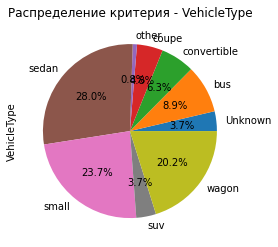

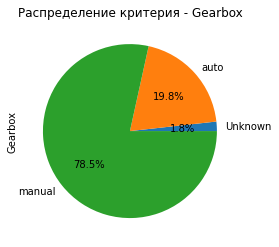

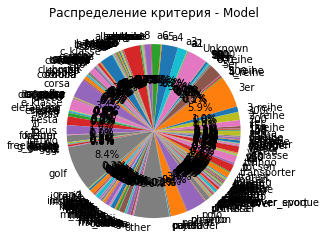

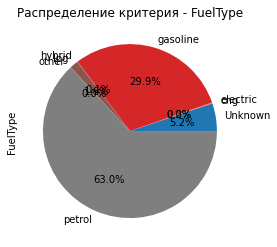

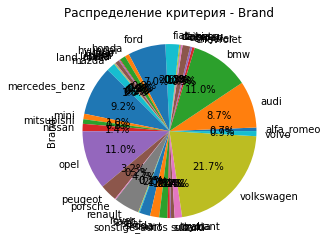

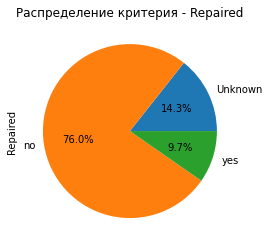

In [17]:
cat_discover(data)

In [18]:
data = data.drop(data[(data['Model'] == 'Unknown')].index).reset_index(drop = True)

<div style="border:solid Chocolate 2px; padding: 40px">
    
<font color = 'green'  size = 5> Результаты проведения исследовательского анализа качественных переменных </font>
    
- Удалены модели типа "Unknown"
- Наибольшей популярностью обрадают автомобили типа седан 
- 75% на рынке это битые машины
- 62% на бензине

### Корреляционный анализ 

In [19]:
def correlation (x, num_cols):
    display('Матрица корреляций  - Коэф. Спримана')
    
    plt.figure (figsize = (7,7))
    sns.heatmap (x.corr(method = 'spearman'), annot = True, cmap = 'cividis')
    plt.show()  
    
    display('Матрица корреляций  - phik Matrix')
    
    plt.figure (figsize = (7,7))
    sns.heatmap (x.phik_matrix(interval_cols = num_cols), annot = True, cmap = 'cividis')
    plt.show()
    
    display('VIF')
    
    x_vif = x[num_cols]
    X = add_constant (x_vif)
    vif_data = pd.Series ([variance_inflation_factor(X.values, i)
                          for i in range (X.shape[1])],
                         index = X.columns)
    display (vif_data)

'Матрица корреляций  - Коэф. Спримана'

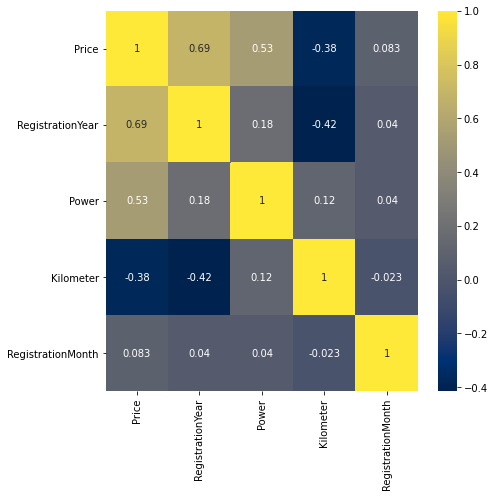

'Матрица корреляций  - phik Matrix'

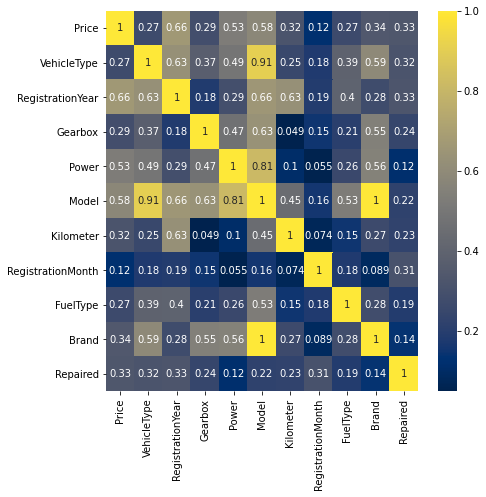

'VIF'

const        20.963759
Price         1.883512
Power         1.600962
Kilometer     1.400788
dtype: float64

In [20]:
correlation(data, ['Price', 'Power', 'Kilometer'])

<div style="border:solid Chocolate 2px; padding: 40px">
    
<font color = 'green'  size = 5> Результаты проведения корреляционного анализа качественных переменных </font>
    
- Мультиколлинеарности нет

## Обучение моделей

Необходимо произвести подготовку данных, а именно, произвести кодирование и масштабирование данных. Преварительно данные нужно разделить на тренировочную и тестовую выборки

In [21]:
RANDOM_STATE = 1234
test_size = 0.25

X = data.drop(columns = 'Price', axis=1)
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = RANDOM_STATE)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

### Подбор не бустинговых моделей

In [22]:
#подготовка данных

cat_features = X_train.select_dtypes(exclude = 'number').columns
num_features = X_train.select_dtypes(include = 'number').columns

ord_pipeline = Pipeline(steps = 
                       [
                           ('SimpleImputer_before_ord',
                           SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                           ('ord',
                            OrdinalEncoder()
                           ),
                           ('SimpleImputer_after_ord', 
                            SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                       ])
data_preprocessor = ColumnTransformer(transformers =
                                     [
                                         ('ord', ord_pipeline, cat_features),
                                         ('num', StandardScaler(), num_features)
                                     ])

X_train_transf = data_preprocessor.fit_transform(X_train)
X_test_transf = data_preprocessor.transform(X_test)

all_features = np.concatenate([cat_features, num_features])

X_train_new = pd.DataFrame(X_train_transf, columns = all_features)
X_test_new = pd.DataFrame(X_test_transf, columns = all_features)

In [23]:
# Поиск лучшей не бустинговой модели

pipeline = Pipeline (
    [
        ('model', [DecisionTreeRegressor(random_state=RANDOM_STATE)])
    ])

params = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__min_samples_leaf': range(1, 16, 5),
        'model__min_samples_split': range(2, 17, 5), 
        'model__max_depth': range(1, 16, 5)
    }
    
]

gs1 = GridSearchCV (estimator = pipeline,
                  param_grid = params,
                  scoring = 'neg_root_mean_squared_error',
                  cv = 3,
                  n_jobs = -1)

gs1.fit(X_train_new, y_train)

print(gs1.best_estimator_)
print((-1) * gs1.best_score_)

Pipeline(steps=[('model',
                 DecisionTreeRegressor(max_depth=11, min_samples_leaf=11,
                                       random_state=1234))])
1853.2138852665712


### Подбор бустинговой модели

In [24]:
cat_features = cat_features.to_list()
pipeline_2 = Pipeline(
    [
        ('model', [LGBMRegressor(cat_features=cat_features)])
    ])

params_2 = [
    {
        'model': [LGBMRegressor()],
        'model__max_depth': [10, 100],
        'model__num_leaves': range (50, 150, 100)
    }
]

gs2 = GridSearchCV (estimator = pipeline_2,
                   param_grid = params_2,
                   scoring = 'neg_root_mean_squared_error',
                   cv = 3,
                   n_jobs = -1)

gs2.fit(X_train_new, y_train)
print(gs2.best_estimator_)
print((-1) * gs2.best_score_)

Pipeline(steps=[('model', LGBMRegressor(max_depth=100, num_leaves=50))])
1573.4583733829495


<div style="border:solid Chocolate 2px; padding: 40px">
    
<font color = 'green'  size = 5> Результаты обучения моделей </font>
    
В результате было обучено 2 модели и подобранны лучшие гиперпараметры: DecisionTreeRegressor и LGBMRegressor. В следующем пункте произведем оценку по времени обучения, а также проверим на тестовой выборке

## Анализ моделей

In [25]:
best_model_tree = gs1.best_estimator_
best_model_lgbm = gs2.best_estimator_

In [26]:
%time 
best_model_tree.fit(X_train_new, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


Pipeline(steps=[('model',
                 DecisionTreeRegressor(max_depth=11, min_samples_leaf=11,
                                       random_state=1234))])

In [27]:
%time 
best_model_lgbm.fit(X_train_new, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


Pipeline(steps=[('model', LGBMRegressor(max_depth=100, num_leaves=50))])

In [28]:
%time 
y_pred_tree = best_model_tree.predict(X_train_new)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [29]:
%time 
y_pred_lgbm = best_model_lgbm.predict(X_train_new)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [30]:
resuls = {'model' : ['DecisionTree', 'LightGBM'],
          'RMSE' : ['1853', '1573'], 
          ' train_time' : ['6.2 µs', '6.68 µs'], 
          'predict_time' : ['8.11 µs', '6.68 µs']}

result = pd.DataFrame(resuls)

result

,model,RMSE,train_time,predict_time
0,DecisionTree,1853,6.2 µs,8.11 µs
1,LightGBM,1573,6.68 µs,6.68 µs


<div style="border:solid Chocolate 2px; padding: 40px">
    
<font color = 'green'  size = 5> Анализ моделей </font>
    
Исходя из анализа, делаем вывод, что модель LGBM имеет большую точность в сравнении с моделью DecisionTree, на 300 пунктов, но скорость обучения и скорость предсказания меньше => время на выполнение больше. 
    
Оценив время обучения, можно сделать вывод что отличается оно на 0.5 микросекунды. Не существенная разница, в то время как достигаются лучшие показатели по точности. 
    
Время предсказания у бустинговой модели меньше
    
Для дальнейшей оценки и проверки на тестовой выборке выбираем модель LightGBM

In [31]:
y_pred_test = best_model_lgbm.predict(X_test_new)

print(mean_squared_error(y_test, y_pred_test) ** 0.5)

1580.3660925154156


<div style="border:solid Chocolate 2px; padding: 40px">
    
<font color = 'green'  size = 5> Анализ моделей </font>
    
Метрика на тестовой выборке 1580. Условие успеха ВЫПОЛНЕНО 
   